<a href="https://colab.research.google.com/github/ankush0939/Zinc-Defficiency-detection-and-Itensity-analysis/blob/main/Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models



# define the transformation for the test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# load the saved model
model = models.vgg16(pretrained=True)

num_features = model.classifier[-1].in_features
new_layer = nn.Linear(num_features, 2)
model.classifier[-1] = new_layer

model.load_state_dict(torch.load('/content/drive/MyDrive/Major Project/model_transfer.pt', map_location=torch.device('cpu')))

# define the test data and labels
test_data = datasets.ImageFolder('/content/drive/MyDrive/Major Project/Dataset/RiceDiseaseDataset/validation', transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

# define the mapping of classes to integer labels
class_to_idx = test_data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# set the model to evaluation mode
model.eval()

# define the criterion for calculating loss
criterion = torch.nn.CrossEntropyLoss()

# define variables for tracking loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# define variables for tracking precision, recall, and f1 score
predictions = []
true_labels = []

# test the model on the test data
with torch.no_grad():
    for data, labels in testloader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item() * data.size(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# calculate the loss and accuracy
test_loss /= total
accuracy = 100.0 * correct / total

# calculate the precision, recall, and f1 score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 0.2522
Test Accuracy: 89.75%
Precision: 0.8983
Recall: 0.8975
F1 Score: 0.8967


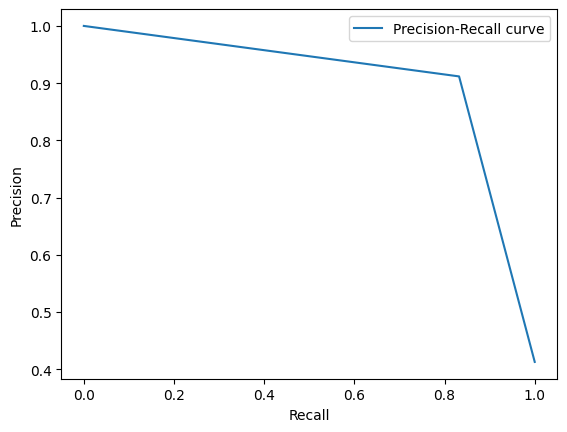

In [3]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# y_true: true labels, y_pred: predicted probabilities of positive class
precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

# plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

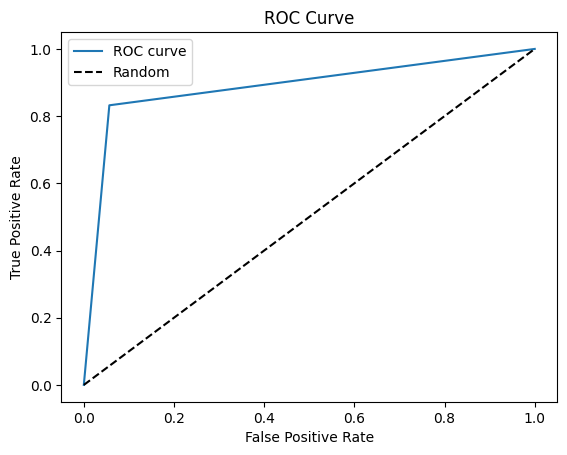


AUROC: 0.8878054957578828


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
 
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# y_true: true labels, y_pred: predicted probabilities of positive class
auroc = roc_auc_score(true_labels, predictions)
print("\nAUROC:", auroc)

**Script to check a batch of images from class directory**

In [34]:
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, models, transforms
import numpy as np

In [35]:
# define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # reshape tensor to (3, H, W)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [36]:
# define the directory containing the image classes to test
class_dir = '/content/drive/MyDrive/Major Project/Dataset/LabelledRice/Labelled'

# define the number of images to load from each class
num_images_per_class = 5

# create a dictionary to hold the images and filenames for each class
class_images = {}

In [37]:
# loop over each class directory
for class_name in os.listdir(class_dir):
    class_images[class_name] = []
    class_path = os.path.join(class_dir, class_name)
    
    # get a list of all the image filenames in the class directory
    image_filenames = os.listdir(class_path)
    
    # choose a random set of image filenames
    random.shuffle(image_filenames)
    image_filenames = image_filenames[:num_images_per_class]
    
    # load the images and apply the transformation
    for filename in image_filenames:
        image_path = os.path.join(class_path, filename)
        with Image.open(image_path) as image:
            image = transform(image)
            class_images[class_name].append((image, filename))

In [38]:
# concatenate the images from each class into a single batch
batch = torch.cat([torch.stack([image for image, _ in class_images[class_name]]) for class_name in class_images], dim=0)

# define the mapping of classes to integer labels
class_to_idx = {class_name: i for i, class_name in enumerate(class_images)}
idx_to_class = {i: class_name for class_name, i in class_to_idx.items()}

# set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [39]:
# load the model and set it to evaluation mode
model = models.vgg16(pretrained=True)
num_features = model.classifier[-1].in_features
new_layer = torch.nn.Linear(num_features, len(class_images))
model.classifier[-1] = new_layer
model.load_state_dict(torch.load('/content/drive/MyDrive/Major Project/model_transfer.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
# move the batch tensor to the device
batch = batch.to(device)

# make predictions using the model
with torch.no_grad():
    output = model(batch)


In [41]:
# get the predicted class probabilities
probs = torch.nn.functional.softmax(output, dim=1)

# get the predicted class labels
_, predicted_labels = torch.max(probs, 1)


In [42]:
# convert the predicted class labels to class names
predicted_classes = [idx_to_class[label.item()] for label in predicted_labels]

In [43]:
import numpy as np



IMG_20190424_131058.jpg: BrownSpot, (BrownSpot)


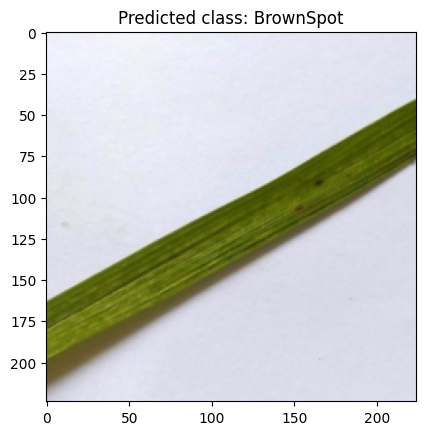



BROWNSPOT3_119.jpg: BrownSpot, (BrownSpot)


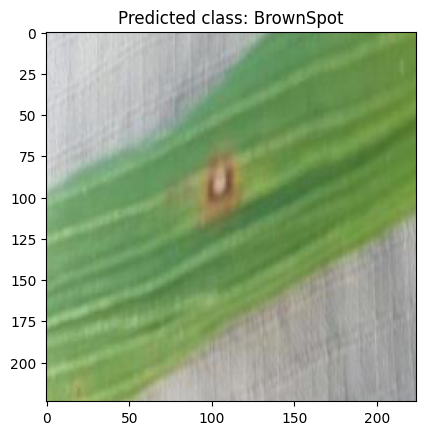



BROWNSPOT5_118.jpg: BrownSpot, (BrownSpot)


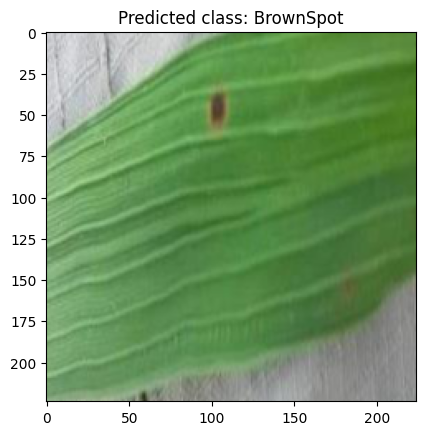



BROWNSPOT7_067.jpg: BrownSpot, (BrownSpot)


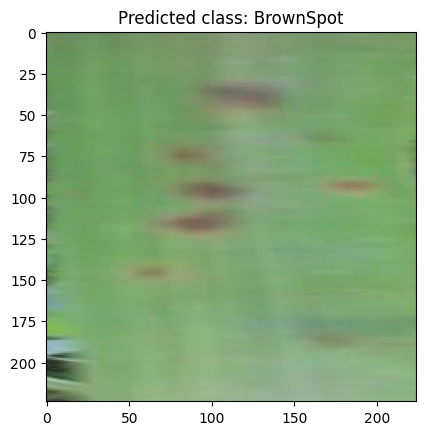



BROWNSPOT3_005.jpg: BrownSpot, (BrownSpot)


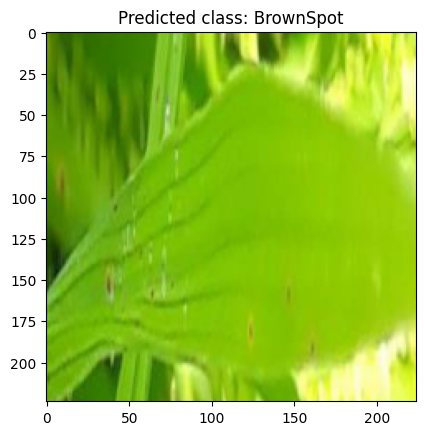



IMG_20190419_124227.jpg: Healthy, (Healthy)


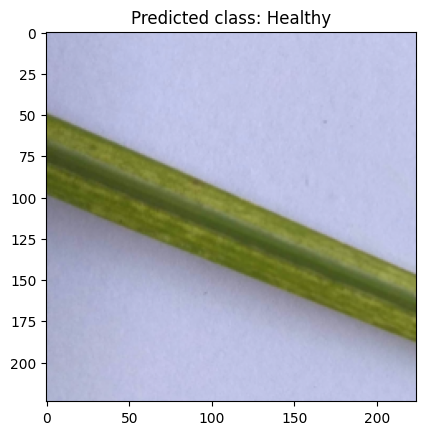



IMG_20190421_195348.jpg: Healthy, (Healthy)


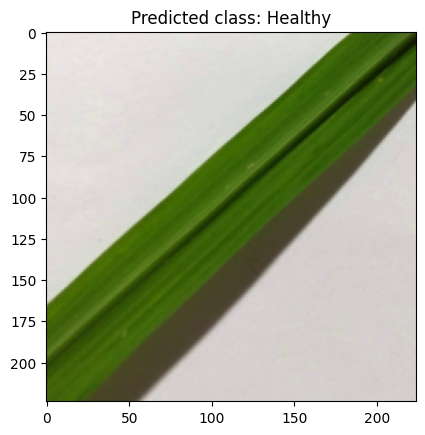



IMG_20190419_164837.jpg: Healthy, (Healthy)


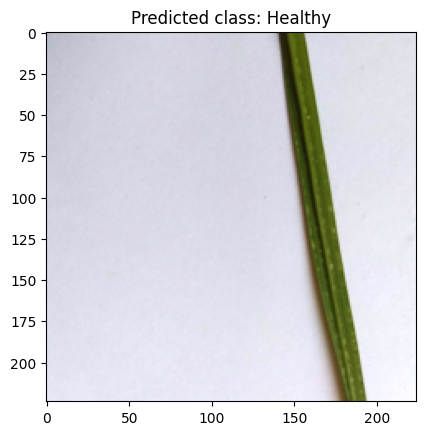



IMG_20190419_172945.jpg: Healthy, (Healthy)


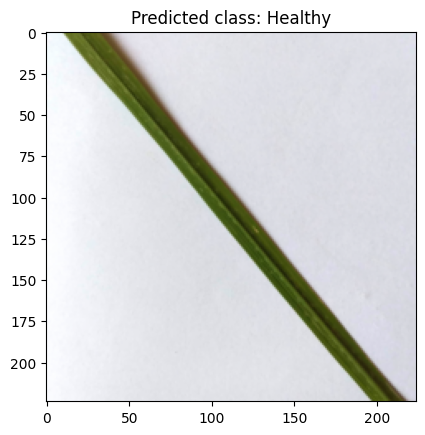



IMG_20190424_133214.jpg: Healthy, (Healthy)


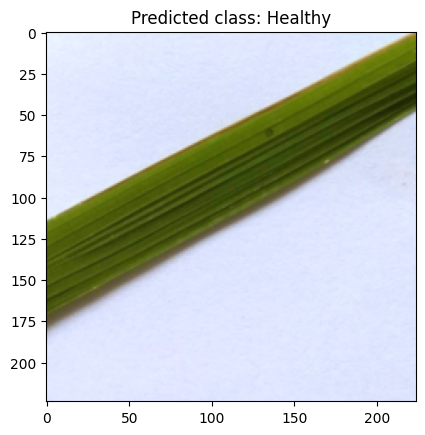

In [46]:
# print the predicted class names and show the images for each image
for i, class_name in enumerate(class_images):
    for j, (image, filename) in enumerate(class_images[class_name]):
        predicted_class = predicted_classes[i * num_images_per_class + j]
        if predicted_class == class_name:
            print(f'\n\n\033[92m{filename}: {predicted_class}, ({class_name})\033[0m')  # print in green for correct predictions
        else:
            print(f'\n\n\033[91m{filename}: {predicted_class}, ({class_name})\033[0m')  # print in red for wrong predictions
        image = image.cpu().numpy().transpose((1, 2, 0))
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f'Predicted class: {predicted_class}')
        plt.show()

In [121]:
# define the directory containing the image to test
image_dir = '/content/drive/MyDrive/Major Project/Intensity/BROWNSPOT3_130.jpg'

# define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # reshape tensor to (3, H, W)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the input image and apply the transform
image = Image.open(image_dir)
image = transform(image)

# remove the extra dimension
image = image.squeeze(0) # remove the batch dimension

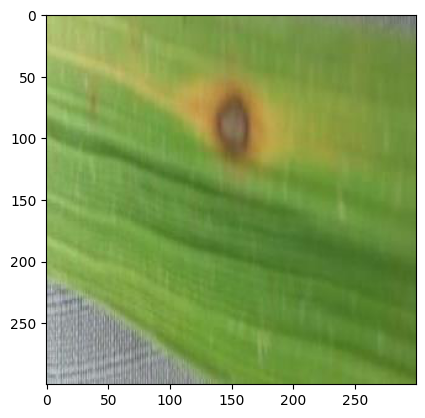

In [122]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image from file
img = mpimg.imread(image_dir)

# Display the image using Matplotlib
plt.imshow(img)
plt.show()

In [123]:
# add an extra dimension to the image tensor to represent the batch
image = image.unsqueeze(0)

# define the mapping of classes to integer labels
class_to_idx = {'BrownSpots': 0, 'Healthy': 1}  # replace with your own class names and indices
idx_to_class = {0: 'BrownSpots', 1: 'Healthy'}

In [124]:
# move the batch tensor to the device
image  = batch.to(device)

# Make predictions using the model
with torch.no_grad():
    output = model(image)

In [125]:
output


tensor([[ 1.0357, -1.3881],
        [ 4.5325, -3.9599],
        [ 4.8966, -4.5466],
        [ 3.2282, -3.2080],
        [ 6.6880, -6.5208],
        [-3.0216,  2.1752],
        [-2.2941,  1.7893],
        [-2.9088,  2.3998],
        [-2.9496,  2.5309],
        [-2.4270,  2.0569]])

In [126]:

# Get the predicted class probabilities
probabilities = torch.nn.functional.softmax(output, dim=1)
probabilities

tensor([[9.1863e-01, 8.1370e-02],
        [9.9980e-01, 2.0498e-04],
        [9.9992e-01, 7.9221e-05],
        [9.9840e-01, 1.5999e-03],
        [1.0000e+00, 1.8344e-06],
        [5.5035e-03, 9.9450e-01],
        [1.6572e-02, 9.8343e-01],
        [4.9244e-03, 9.9508e-01],
        [4.1498e-03, 9.9585e-01],
        [1.1163e-02, 9.8884e-01]])

In [127]:
# get the predicted class labels
_, predicted_labels = torch.max(probs, 1)
predicted_labels

tensor([0])

In [128]:
# convert the predicted class labels to class names
predicted_classes = [idx_to_class[label.item()] for label in predicted_labels]
predicted_classes

['BrownSpots']

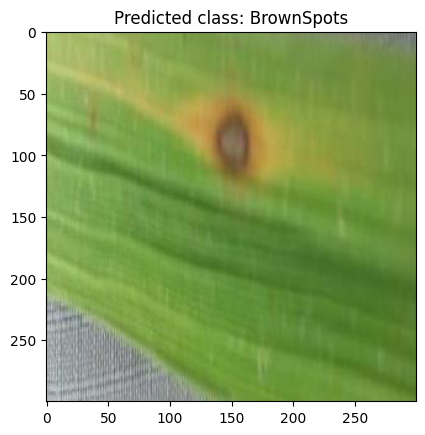

In [129]:
# Load the image from file
img = mpimg.imread(image_dir)

# Display the image using Matplotlib
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class}')
plt.show()

**Intensity**

In [136]:
import cv2 
import matplotlib.pyplot as plt

In [140]:
img = cv2.imread('/content/drive/MyDrive/Major Project/Intensity/BROWNSPOT1_127.jpg')

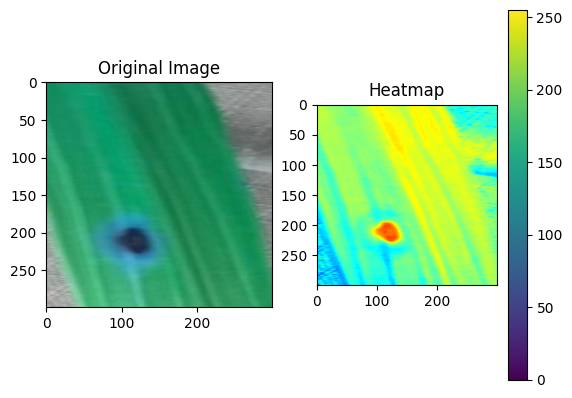

In [145]:
import matplotlib.pyplot as plt

# Normalize the pixel values to improve sensitivity to high intensities
normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Apply color mapping to create a heatmap
heatmap = cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Display the original image and the heatmap using Matplotlib
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
im2 = ax2.imshow(heatmap)
ax2.set_title('Heatmap')
fig.colorbar(im2, ax=ax2)
plt.show()